# Blue Carbon Analysis

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt

In [4]:
# Trigger the authentication flow
# need to do it when it is first time to run this notebook
# will be directed for permission confirmation 
# and The authorization workflow will generate a code, 
# which you should paste in the box below.
ee.Authenticate()

Enter verification code:  4/1AVMBsJgWACO8UxJXAGkvYQ1PVBQCOBoJerTiCW9E5zZDX3654k11AvQ7rjU



Successfully saved authorization token.


In [2]:
# Initialize
ee.Initialize()

In [5]:
# replace the file path below with yours
pa_path = r'../Blue/Calyx_VCS_2250_Maps/Project Area/Calyx_VCS_2250_project.shp'
aoi = geemap.shp_to_ee(pa_path)

In [6]:
# calculate its area in ha
pa_area = round(aoi.geometry().area(1).getInfo()/10000, 2)
print(f'Project area:{pa_area} ha')

Project area:518025.89 ha


In [7]:
# Display project area in google earth engine
Map = geemap.Map()
Map.addLayer(aoi, {'color': 'blue'}, 'Project Area')
Map

Map(bottom=14383.0, center=[24.5, 68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

### Surface water dynamics analysis using GSW dataset

In [44]:
# load the dataset and clip with project area
gsw = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
change_abs = gsw.select('change_abs').clip(aoi)

In [15]:
yearly = ee.ImageCollection('JRC/GSW1_4/YearlyHistory').filterBounds(aoi)

def mean_occurrence(start_year, end_year):
    filtered = yearly.filter(ee.Filter.calendarRange(start_year, end_year, 'year'))
    
    def water_mask(img):
        return img.select('waterClass').eq(2).rename('water')  # water=1, else=0
    
    water_masked = filtered.map(water_mask)
    mean_img = water_masked.mean().multiply(100).clip(aoi)
    return mean_img.rename('occurrence')

# Compute mean occurrence for two periods
occ_pre = mean_occurrence(1984, 1999)
occ_post = mean_occurrence(2000, 2020)

# Calculate delta (post - pre)
delta_yearly = occ_post.subtract(occ_pre).rename('delta_yearly')

In [51]:
# Visualization parameters
vis_params = {
    'min': -50,
    'max': 50,
    'palette': ['darkred', 'white', 'darkblue']
}

In [15]:
# Display: create map and add layers side-by-side
Map = geemap.Map(center=[24.5, 68], zoom=8)
# Add change_abs layer (precomputed)
change_abs_layer = geemap.ee_tile_layer(change_abs, vis_params, 'change_abs (JRC)')
# Add yearly delta layer (calculated)
delta_yearly_layer = geemap.ee_tile_layer(delta_yearly, vis_params, 'YearlyHistory Delta')
Map.split_map(change_abs_layer, delta_yearly_layer)
Map

Map(bottom=903574.0, center=[24.19029240477738, 67.46661186218263], controls=(ZoomControl(options=['position',…

In [16]:
# calculate area
def get_histogram(image, band_name, aoi, scale=30):
    stats = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=50),
        geometry=aoi,
        scale=scale,
        maxPixels=1e9
    ).get(band_name)
    return stats.getInfo()

In [17]:
# Get histograms
hist_abs = get_histogram(change_abs, 'change_abs', aoi)
hist_custom = get_histogram(delta_custom, 'delta', aoi)

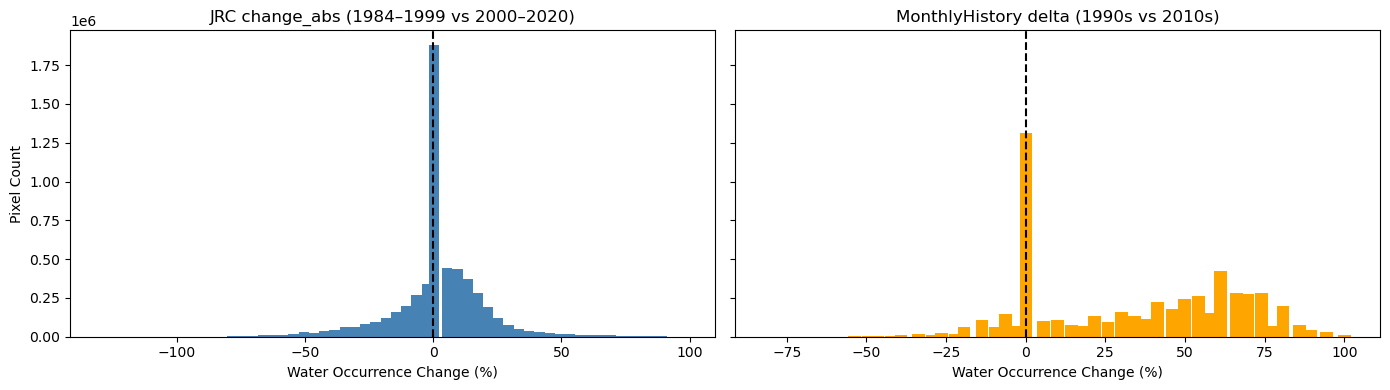

In [18]:
# ---------------------------------------
# Plot side-by-side histograms
# ---------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Left: change_abs
axes[0].bar(hist_abs['bucketMeans'], hist_abs['histogram'], width=4, color='steelblue')
axes[0].axvline(0, color='black', linestyle='--')
axes[0].set_title('JRC change_abs (1984–1999 vs 2000–2020)')
axes[0].set_xlabel('Water Occurrence Change (%)')
axes[0].set_ylabel('Pixel Count')

# Right: delta_custom
axes[1].bar(hist_custom['bucketMeans'], hist_custom['histogram'], width=4, color='orange')
axes[1].axvline(0, color='black', linestyle='--')
axes[1].set_title('MonthlyHistory delta (1990s vs 2010s)')
axes[1].set_xlabel('Water Occurrence Change (%)')

plt.tight_layout()
plt.show()

In [46]:
# count water loss and again in project area
def count_gain_loss_area(image, band_name, geometry, scale=30):
    pixel_area = ee.Image.pixelArea()

    gain_mask = image.gt(30)
    loss_mask = image.lt(-30)

    gain_area_image = pixel_area.updateMask(gain_mask)
    loss_area_image = pixel_area.updateMask(loss_mask)

    gain_area = gain_area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=scale,
        maxPixels=1e9
    ).get('area')

    loss_area = loss_area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=scale,
        maxPixels=1e9
    ).get('area')

    # Convert to hectares
    gain_ha = ee.Number(gain_area).divide(10000).getInfo() if gain_area else 0
    loss_ha = ee.Number(loss_area).divide(10000).getInfo() if loss_area else 0

    return gain_ha, loss_ha

In [47]:
gain_ha, loss_ha = count_gain_loss_area(change_abs, 'change_abs', aoi)
print(f"Water gain area: {gain_ha} hectares")
print(f"Water loss area: {loss_ha} hectares")

Water gain area: 21034.533800292178 hectares
Water loss area: 23471.515328520392 hectares


### Mangrove coverage dynamics analysis

In [10]:
# Load extent rasters for 1996 and 2020
extent_raster = ee.ImageCollection("projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/extent/GMW_V3")
extent_1996 = extent_raster.filterDate('1996-01-01', '1996-12-31').first().clip(aoi)
extent_2015 = extent_raster.filterDate('2015-01-01', '2015-12-31').first().clip(aoi)
extent_2020 = extent_raster.filterDate('2020-01-01', '2020-12-31').first().clip(aoi)

In [11]:
# Mask non-mangrove pixels (assuming mangrove pixels = 1)
mangrove_1996 = extent_1996.eq(1)
mangrove_2015 = extent_2015.eq(1)
mangrove_2020 = extent_2020.eq(1)

# Calculate pixel area in hectares
pixel_area_ha = ee.Image.pixelArea().divide(10000)

# Multiply masks by pixel area
area_img_1996 = pixel_area_ha.updateMask(mangrove_1996)
area_img_2015 = pixel_area_ha.updateMask(mangrove_2015)
area_img_2020 = pixel_area_ha.updateMask(mangrove_2020)

# Reduce to total area
area_1996 = area_img_1996.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi,
    scale=30,
    maxPixels=1e10
)

area_2015 = area_img_2015.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi,
    scale=30,
    maxPixels=1e10
)

area_2020 = area_img_2020.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi,
    scale=30,
    maxPixels=1e10
)

# Print the results
print("Mangrove area in 1996 (ha):", area_1996.getInfo().get('area'))
print("Mangrove area in 2015 (ha):", area_2015.getInfo().get('area'))
print("Mangrove area in 2020 (ha):", area_2020.getInfo().get('area'))

Mangrove area in 1996 (ha): 86038.55443609475
Mangrove area in 2015 (ha): 72962.5311871273
Mangrove area in 2020 (ha): 66127.05670340236


In [12]:
# Display
Map = geemap.Map(center=[24.3, 67.3], zoom=9)
Map.addLayer(ee.Image().paint(aoi, 0, 2), {'palette': 'blue'}, 'AOI')
Map.addLayer(mangrove_1996.updateMask(mangrove_1996), {'palette': 'green'}, 'Mangrove 1996')
Map.addLayer(mangrove_2015.updateMask(mangrove_2015), {'palette': 'green'}, 'Mangrove 2015')
Map.addLayer(mangrove_2020.updateMask(mangrove_2020), {'palette': 'green'}, 'Mangrove 2020')
Map

Map(center=[24.3, 67.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [60]:
# Load mangrove coverage change image (loss = 1, gain = 2)
change_image = ee.ImageCollection("projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/change/change_f1996") \
    .sort('system:time_end', False).first().clip(aoi)

# Define visualization styles
extent_vis = {"bands": ["b1"], "min": 1, "max": 1, "palette": ["#228B22"]}
change_vis = {"bands": ["b1"], "min": 1, "max": 2, "palette": ["#0000FF", "#FF0000"]}

# Create interactive map
Map = geemap.Map(center=[24.10, 67.48], zoom=9)

# Add layers
Map.addLayer(ee.Image().paint(aoi, 0, 2), {'palette': 'blue'}, 'AOI')
Map.addLayer(extent_1996, extent_vis, 'Mangrove Extent 1996')
Map.addLayer(extent_2020, extent_vis, 'Mangrove Extent 2020')
Map.addLayer(change_image, change_vis, 'Mangrove Change 1996–2020 (Loss/ Gain)')

# Add legend
Map.add_legend(title="Mangrove Change", legend_dict={
    "Loss (1996–2020)": "#FF0000",
    "Gain (1996–2020)": "#0000FF",
    "Extent (1996 or 2020)": "#228B22"
})

Map

Map(center=[24.1, 67.48], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [14]:
# Load GMW change image: 1 = gain, 2 = loss
# Each pixel is 30m x 30m = 900 m² = 0.09 ha
pixel_area_ha = ee.Image.pixelArea().divide(10000)  # m² to ha

# Mask and compute area for gain (value = 1)
gain_mask = change_image.eq(1)
gain_area = pixel_area_ha.updateMask(gain_mask)

# Mask and compute area for loss (value = 2)
loss_mask = change_image.eq(2)
loss_area = pixel_area_ha.updateMask(loss_mask)

# Sum up the areas within AOI
gain_stats = gain_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi,
    scale=30,
    maxPixels=1e13
)

loss_stats = loss_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi,
    scale=30,
    maxPixels=1e13
)

# Print result
print('Mangrove gain area (ha):', gain_stats.getInfo()['area'])
print('Mangrove loss area (ha):', loss_stats.getInfo()['area'])

Mangrove gain area (ha): 2079.7398235802175
Mangrove loss area (ha): 21991.237556259577


### Overlap mangrove coverage change and surface water change 

In [17]:
# Load GMW mangrove change image: 1 = gain, 2 = loss
gmw_change = ee.ImageCollection(
    "projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/change/change_f1996"
).sort('system:time_end', False).first().clip(aoi)

# Load JRC Surface Water absolute change image (-100 to 100)
jrc_change_abs = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('change_abs').clip(aoi)

# Define water gain/loss masks using ±30% threshold
water_gain = jrc_change_abs.gt(30)
water_loss = jrc_change_abs.lt(-30)

# Mangrove gain/loss masks
mangrove_gain = gmw_change.eq(1)
mangrove_loss = gmw_change.eq(2)

In [68]:
# Visualization
Map = geemap.Map(center=[24.3, 67.3], zoom=9)
Map.addLayer(ee.Image().paint(aoi, 0, 2), {'palette': 'blue'}, 'AOI')
Map.addLayer(water_gain.updateMask(water_gain), {'palette': 'cyan'}, 'Water Gain (>30%)')
Map.addLayer(water_loss.updateMask(water_loss), {'palette': 'red'}, 'Water Loss (<-30%)')
Map.addLayer(mangrove_gain.updateMask(mangrove_gain), {'palette': 'green'}, 'Mangrove Gain')
Map.addLayer(mangrove_loss.updateMask(mangrove_loss), {'palette': 'orange'}, 'Mangrove Loss')
# Map.addLayer(overlap_gain.updateMask(overlap_gain), {'palette': 'green'}, 'Overlap: Water Gain + Mangrove Gain')
# Map.addLayer(overlap_loss.updateMask(overlap_loss), {'palette': 'black'}, 'Overlap: Water Loss + Mangrove Loss')

Map.add_legend(
    title="Change Overlap",
    legend_dict={
        "Water Gain (>30%)": "#00FFFF",     # Cyan
        "Water Loss (<-30%)": "#FF0000",    # Red
        "Mangrove Gain": "#008000",         # Green
        "Mangrove Loss": "#FFA500"          # Orange
    }
)
Map

Map(center=[24.3, 67.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [50]:
# calculation 
jrc = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('change_abs').clip(aoi)

# Threshold water gain and loss:
# Per doc, change_abs < 0 means water loss, > 0 means water gain, 0 no change
water_gain = jrc.gt(30).rename('water_gain')    # 1 if gain, 0 else
water_loss = jrc.lt(-30).rename('water_loss')    # 1 if loss, 0 else

# Load GMW mangrove change raster 1996-2020 (1 = gain, 2 = loss)
# You may need to replace this with your specific mangrove change dataset path
mangrove_change = ee.ImageCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/change/change_f1996').sort('system:time_end', False).first().clip(aoi)

# Create masks for mangrove gain and loss
mangrove_gain = mangrove_change.eq(1).rename('mangrove_gain')
mangrove_loss = mangrove_change.eq(2).rename('mangrove_loss')

# Combine layers to get all combinations (0/1 masks)
combined = water_gain.addBands([water_loss, mangrove_gain, mangrove_loss])

# Define pixel area in hectares (1 hectare = 10,000 m²)
pixel_area_ha = ee.Image.pixelArea().divide(10000)

# Define functions to calculate area for each combination
def calc_area(mask_condition):
    masked_area_image = pixel_area_ha.updateMask(mask_condition)
    stats = masked_area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30,
        maxPixels=1e10
    )
    return stats.get('area').getInfo()

# Conditions:
# 1. Water Gain & Mangrove Loss
cond1 = combined.select('water_gain').eq(1).And(combined.select('mangrove_loss').eq(1))
area1 = calc_area(cond1)

# 2. Water Loss & Mangrove Gain
cond2 = combined.select('water_loss').eq(1).And(combined.select('mangrove_gain').eq(1))
area2 = calc_area(cond2)

# 3. Water Gain & Mangrove Gain
cond3 = combined.select('water_gain').eq(1).And(combined.select('mangrove_gain').eq(1))
area3 = calc_area(cond3)

# 4. Water Loss & Mangrove Loss
cond4 = combined.select('water_loss').eq(1).And(combined.select('mangrove_loss').eq(1))
area4 = calc_area(cond4)

print("Area (ha) where Water Gain & Mangrove Loss:", area1)
print("Area (ha) where Water Loss & Mangrove Gain:", area2)
print("Area (ha) where Water Gain & Mangrove Gain:", area3)
print("Area (ha) where Water Loss & Mangrove Loss:", area4)

Area (ha) where Water Gain & Mangrove Loss: 1780.5309261936845
Area (ha) where Water Loss & Mangrove Gain: 853.7632377513023
Area (ha) where Water Gain & Mangrove Gain: 6.9545439514160154
Area (ha) where Water Loss & Mangrove Loss: 1234.266875092112


In [30]:
# Visualization with geemap (optional)
Map = geemap.Map(center=[24.5, 67], zoom=8)
Map.addLayer(aoi, {}, 'Region', False)
Map.addLayer(water_gain.updateMask(water_gain), {'palette': 'blue'}, 'Water Gain')
Map.addLayer(water_loss.updateMask(water_loss), {'palette': 'red'}, 'Water Loss')
Map.addLayer(mangrove_gain.updateMask(mangrove_gain), {'palette': 'green'}, 'Mangrove Gain')
Map.addLayer(mangrove_loss.updateMask(mangrove_loss), {'palette': 'orange'}, 'Mangrove Loss')
Map

Map(center=[24.5, 67], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

### Vegetation NDVI change analysis in project area

In [28]:
gmw_core_vector = ee.FeatureCollection("projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/core/gmw_v3_core_vec")
core = gmw_core_vector.filterBounds(aoi)

# Cloud mask and NDVI functions as before
def maskL457sr(image):
    qa = image.select('QA_PIXEL')
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
        qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

def maskL8sr(image):
    qa = image.select('QA_PIXEL')
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
        qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

def addNDVI_L57(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')
    return image.addBands(ndvi)

def addNDVI_L8(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

# Load Landsat collections, filter Aug only, cloud mask and add NDVI
landsat57 = (ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
             .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'))
             .filterDate('1990-01-01', '2013-05-31')
             .filter(ee.Filter.calendarRange(5, 9, 'month'))
             .map(maskL457sr)
             .map(addNDVI_L57)
             .filterBounds(aoi))

landsat8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterDate('2013-06-01', '2023-12-31')
            .filter(ee.Filter.calendarRange(5, 9, 'month'))
            .map(maskL8sr)
            .map(addNDVI_L8)
            .filterBounds(aoi))

all_landsat = landsat57.merge(landsat8)

# Get list of years in the period
years = ee.List.sequence(1990, 2023)

# Function to compute annual median NDVI for each year
def annual_ndvi(year):
    start = ee.Date.fromYMD(year, 5, 1)
    end = ee.Date.fromYMD(year, 9, 30)
    annualCollection = all_landsat.filterDate(start, end)
    annualNDVI = annualCollection.select('NDVI').median().clip(aoi)
    return annualNDVI.set('year', year)

annual_ndvi_collection = ee.ImageCollection(years.map(annual_ndvi))

def reduce_to_mean(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=core,
        scale=30,
        maxPixels=1e13
    )
    return ee.Feature(None, {'year': image.get('year'), 'mean_ndvi': mean_dict.get('NDVI')})

ndvi_features = annual_ndvi_collection.map(reduce_to_mean)

ndvi_dict = ndvi_features.aggregate_array('year').getInfo()
mean_ndvi = ndvi_features.aggregate_array('mean_ndvi').getInfo()

# Create DataFrame
df = pd.DataFrame({'Year': ndvi_dict, 'Mean NDVI': mean_ndvi})
df = df.sort_values('Year')

# Plot
plt.figure(figsize=(12,6))
plt.bar(df['Year'], df['Mean NDVI'], color='#228B22')
plt.xlabel('Year')
plt.ylabel('Mean NDVI')
plt.title('Annual Mean NDVI in Core Mangrove Area (1990–2023)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('Annual_Mean_NDVI_Core_Mangrove_Area.jpeg')
plt.show()

In [26]:
# For example: visualize the NDVI for 2000
ndvi_1996 = annual_ndvi_collection.filterMetadata('year', 'equals', 1996).first()
ndvi_2000 = annual_ndvi_collection.filterMetadata('year', 'equals', 2000).first()
ndvi_2020 = annual_ndvi_collection.filterMetadata('year', 'equals', 2020).first()
# Visualization parameters for NDVI
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['white', 'green']}

# Create a map and add the NDVI 2000 layer
Map = geemap.Map(center=[24.5, 67.5], zoom=8)
Map.addLayer(ndvi_1996, ndvi_vis, 'NDVI 1996')
Map.addLayer(ndvi_2000, ndvi_vis, 'NDVI 2000')
Map.addLayer(ndvi_2020, ndvi_vis, 'NDVI 2020')
Map.addLayer(ee.Image().paint(aoi, 0, 2), {'palette': 'red'}, 'AOI')
Map

Map(center=[24.5, 67.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [11]:
gmw_core = ee.Image("projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/core/gmw_v3_mng_core").clip(aoi)

In [ ]:
# Mask NDVI by GMW core mangrove extent
ndvi_core_1996 = ndvi_1996.updateMask(gmw_core)
ndvi_core_2020 = ndvi_2020.updateMask(gmw_core)

# Calculate mean NDVI over core mangroves
def mean_ndvi(image, year):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e10
    )
    return f"{year} mean NDVI in core mangroves: {stats.get('NDVI').getInfo():.4f}"

print(mean_ndvi(ndvi_core_1996, 1996))
print(mean_ndvi(ndvi_core_2020, 2020))

In [67]:
# Visualize
Map = geemap.Map(center=[24.5, 67], zoom=8)
Map.addLayer(ee.Image().paint(aoi, 0, 2), {'palette': 'blue'}, 'AOI')
Map.addLayer(ndvi_core_1996, {'min': 0, 'max': 0.8, 'palette': ['white', 'green']}, 'NDVI 1996 (core)')
Map.addLayer(ndvi_core_2020, {'min': 0, 'max': 0.8, 'palette': ['white', 'darkgreen']}, 'NDVI 2020 (core)')
Map.addLayer(gmw_core, {'min': 1, 'max': 1, 'palette': ['yellow']}, 'GMW Core')
Map

Map(center=[24.5, 67], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…